In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import *

In [ ]:
# from imblearn.combine import SMOTETomek
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import OneSidedSelection
# from imblearn.under_sampling import TomekLinks

In [4]:
import time
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [5]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

### Getting Data

In [6]:
res = pd.read_csv('../Outputs/resampled_cat.csv', encoding='cp949', index_col=0)
test = pd.read_csv('../Outputs/test_set_cat.csv', encoding='cp949', index_col=0)
res = res.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [9]:
X_res, y_res = res.iloc[:, :-1], res.iloc[:, -1] 
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

### Model Fitting

In [22]:
def objective(trial: Trial, X_train, y_train):
    params = {
        'n_estimators':trial.suggest_int('n_estimators', 50, 600),
        'learning_rate':trial.suggest_float('learning_rate', 0.0005, 0.3),
        'depth':trial.suggest_int('depth', 3, 12),
        'cat_features':['인접도로구분', '브랜드']
    }
    
    cat_model = CatBoostClassifier(**params, cat_features=['인접도로구분', '브랜드'],
                                   verbose=1, eval_metric='AUC', random_state=42)
    cat_model.fit(X_train, y_train)
    if trial.should_prune():
        raise optuna.TrialPruned()

    y_pred = cat_model.predict(X_test)
    score = roc_auc_score(y_test, y_pred)                                               
    # score = cross_val_score(lg_model, X_train, y_train, cv=3, scoring='roc_auc').mean()
    
    return score

In [25]:
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial:objective(trial, X_res, y_res), n_trials=20)

[I 2024-06-06 16:20:24,870] A new study created in memory with name: no-name-f8e46d46-f76c-44f2-845a-5905eab28a93


0:	total: 140ms	remaining: 14.3s
1:	total: 265ms	remaining: 13.4s
2:	total: 394ms	remaining: 13.1s
3:	total: 543ms	remaining: 13.4s
4:	total: 695ms	remaining: 13.6s
5:	total: 847ms	remaining: 13.7s
6:	total: 985ms	remaining: 13.5s
7:	total: 1.12s	remaining: 13.3s
8:	total: 1.27s	remaining: 13.3s
9:	total: 1.4s	remaining: 13.1s
10:	total: 1.54s	remaining: 12.9s
11:	total: 1.68s	remaining: 12.8s
12:	total: 1.85s	remaining: 12.8s
13:	total: 2.05s	remaining: 13s
14:	total: 2.2s	remaining: 12.9s
15:	total: 2.37s	remaining: 12.9s
16:	total: 2.64s	remaining: 13.4s
17:	total: 2.77s	remaining: 13.1s
18:	total: 2.91s	remaining: 12.9s
19:	total: 3.05s	remaining: 12.7s
20:	total: 3.19s	remaining: 12.5s
21:	total: 3.32s	remaining: 12.2s
22:	total: 3.47s	remaining: 12.1s
23:	total: 3.6s	remaining: 11.8s
24:	total: 3.74s	remaining: 11.7s
25:	total: 3.87s	remaining: 11.5s
26:	total: 4.01s	remaining: 11.3s
27:	total: 4.18s	remaining: 11.2s
28:	total: 4.35s	remaining: 11.1s
29:	total: 4.47s	remaining: 1

[I 2024-06-06 16:20:41,402] Trial 0 finished with value: 0.5857117599609815 and parameters: {'iteration': 103, 'learning_rate': 0.12461418362618623, 'depth': 6}. Best is trial 0 with value: 0.5857117599609815.


0:	total: 96.7ms	remaining: 15.2s
1:	total: 207ms	remaining: 16.1s
2:	total: 307ms	remaining: 15.9s
3:	total: 425ms	remaining: 16.4s
4:	total: 547ms	remaining: 16.7s
5:	total: 684ms	remaining: 17.3s
6:	total: 823ms	remaining: 17.8s
7:	total: 921ms	remaining: 17.3s
8:	total: 1.04s	remaining: 17.2s
9:	total: 1.15s	remaining: 17s
10:	total: 1.24s	remaining: 16.5s
11:	total: 1.33s	remaining: 16.3s
12:	total: 1.45s	remaining: 16.2s
13:	total: 1.54s	remaining: 15.8s
14:	total: 1.66s	remaining: 15.8s
15:	total: 1.78s	remaining: 15.8s
16:	total: 1.92s	remaining: 15.9s
17:	total: 2.07s	remaining: 16.1s
18:	total: 2.15s	remaining: 15.8s
19:	total: 2.26s	remaining: 15.6s
20:	total: 2.35s	remaining: 15.4s
21:	total: 2.47s	remaining: 15.3s
22:	total: 2.55s	remaining: 15s
23:	total: 2.71s	remaining: 15.1s
24:	total: 2.9s	remaining: 15.4s
25:	total: 3.07s	remaining: 15.6s
26:	total: 3.19s	remaining: 15.5s
27:	total: 3.42s	remaining: 15.9s
28:	total: 3.61s	remaining: 16.1s
29:	total: 3.81s	remaining: 

[I 2024-06-06 16:21:01,134] Trial 1 finished with value: 0.5893517389510017 and parameters: {'iteration': 158, 'learning_rate': 0.16964168270911012, 'depth': 3}. Best is trial 1 with value: 0.5893517389510017.


0:	total: 121ms	remaining: 1m 10s
1:	total: 240ms	remaining: 1m 9s
2:	total: 376ms	remaining: 1m 12s
3:	total: 507ms	remaining: 1m 13s
4:	total: 641ms	remaining: 1m 14s
5:	total: 764ms	remaining: 1m 13s
6:	total: 896ms	remaining: 1m 13s
7:	total: 1.03s	remaining: 1m 14s
8:	total: 1.18s	remaining: 1m 15s
9:	total: 1.32s	remaining: 1m 15s
10:	total: 1.47s	remaining: 1m 16s
11:	total: 1.73s	remaining: 1m 22s
12:	total: 1.89s	remaining: 1m 23s
13:	total: 2.08s	remaining: 1m 24s
14:	total: 2.21s	remaining: 1m 23s
15:	total: 2.38s	remaining: 1m 24s
16:	total: 2.58s	remaining: 1m 26s
17:	total: 2.72s	remaining: 1m 25s
18:	total: 2.88s	remaining: 1m 25s
19:	total: 3.08s	remaining: 1m 26s
20:	total: 3.23s	remaining: 1m 26s
21:	total: 3.46s	remaining: 1m 28s
22:	total: 3.62s	remaining: 1m 28s
23:	total: 3.77s	remaining: 1m 28s
24:	total: 3.97s	remaining: 1m 28s
25:	total: 4.21s	remaining: 1m 30s
26:	total: 4.35s	remaining: 1m 29s
27:	total: 4.58s	remaining: 1m 30s
28:	total: 4.72s	remaining: 1m 

[I 2024-06-06 16:22:25,004] Trial 2 finished with value: 0.5951793351842125 and parameters: {'iteration': 584, 'learning_rate': 0.09578623298219022, 'depth': 4}. Best is trial 2 with value: 0.5951793351842125.


583:	total: 1m 22s	remaining: 0us
0:	total: 574ms	remaining: 3m 51s
1:	total: 1.17s	remaining: 3m 54s
2:	total: 1.9s	remaining: 4m 13s
3:	total: 2.52s	remaining: 4m 12s
4:	total: 3.1s	remaining: 4m 7s
5:	total: 3.81s	remaining: 4m 12s
6:	total: 4.44s	remaining: 4m 11s
7:	total: 5.19s	remaining: 4m 16s
8:	total: 5.82s	remaining: 4m 15s
9:	total: 6.59s	remaining: 4m 19s
10:	total: 7.33s	remaining: 4m 21s
11:	total: 8.12s	remaining: 4m 25s
12:	total: 8.74s	remaining: 4m 22s
13:	total: 9.4s	remaining: 4m 22s
14:	total: 10.1s	remaining: 4m 21s
15:	total: 10.7s	remaining: 4m 18s
16:	total: 11.2s	remaining: 4m 15s
17:	total: 11.9s	remaining: 4m 14s
18:	total: 12.6s	remaining: 4m 14s
19:	total: 13.2s	remaining: 4m 12s
20:	total: 14s	remaining: 4m 14s
21:	total: 14.6s	remaining: 4m 13s
22:	total: 15.2s	remaining: 4m 11s
23:	total: 15.7s	remaining: 4m 9s
24:	total: 16.3s	remaining: 4m 7s
25:	total: 16.9s	remaining: 4m 5s
26:	total: 17.5s	remaining: 4m 4s
27:	total: 18.1s	remaining: 4m 2s
28:	tot

[I 2024-06-06 16:26:20,230] Trial 3 finished with value: 0.5853129924214001 and parameters: {'iteration': 404, 'learning_rate': 0.13702283294530335, 'depth': 11}. Best is trial 2 with value: 0.5951793351842125.


0:	total: 93.7ms	remaining: 53.8s
1:	total: 218ms	remaining: 1m 2s
2:	total: 396ms	remaining: 1m 15s
3:	total: 543ms	remaining: 1m 17s
4:	total: 724ms	remaining: 1m 22s
5:	total: 851ms	remaining: 1m 20s
6:	total: 967ms	remaining: 1m 18s
7:	total: 1.07s	remaining: 1m 16s
8:	total: 1.19s	remaining: 1m 14s
9:	total: 1.31s	remaining: 1m 14s
10:	total: 1.44s	remaining: 1m 13s
11:	total: 1.53s	remaining: 1m 11s
12:	total: 1.64s	remaining: 1m 10s
13:	total: 1.76s	remaining: 1m 10s
14:	total: 1.88s	remaining: 1m 10s
15:	total: 2.01s	remaining: 1m 10s
16:	total: 2.12s	remaining: 1m 9s
17:	total: 2.22s	remaining: 1m 8s
18:	total: 2.36s	remaining: 1m 9s
19:	total: 2.5s	remaining: 1m 9s
20:	total: 2.62s	remaining: 1m 9s
21:	total: 2.74s	remaining: 1m 8s
22:	total: 2.87s	remaining: 1m 8s
23:	total: 3s	remaining: 1m 8s
24:	total: 3.09s	remaining: 1m 8s
25:	total: 3.23s	remaining: 1m 8s
26:	total: 3.36s	remaining: 1m 8s
27:	total: 3.48s	remaining: 1m 7s
28:	total: 3.6s	remaining: 1m 7s
29:	total: 3.7

[I 2024-06-06 16:27:27,401] Trial 4 finished with value: 0.590177834471374 and parameters: {'iteration': 575, 'learning_rate': 0.26044939559073577, 'depth': 3}. Best is trial 2 with value: 0.5951793351842125.


0:	total: 396ms	remaining: 3m 30s
1:	total: 806ms	remaining: 3m 34s
2:	total: 1.2s	remaining: 3m 32s
3:	total: 1.58s	remaining: 3m 29s
4:	total: 2.02s	remaining: 3m 33s
5:	total: 2.41s	remaining: 3m 31s
6:	total: 2.84s	remaining: 3m 34s
7:	total: 3.25s	remaining: 3m 34s
8:	total: 3.65s	remaining: 3m 32s
9:	total: 4.04s	remaining: 3m 31s
10:	total: 4.43s	remaining: 3m 30s
11:	total: 4.81s	remaining: 3m 29s
12:	total: 5.22s	remaining: 3m 29s
13:	total: 5.62s	remaining: 3m 28s
14:	total: 6.07s	remaining: 3m 30s
15:	total: 6.61s	remaining: 3m 33s
16:	total: 7.02s	remaining: 3m 33s
17:	total: 7.44s	remaining: 3m 33s
18:	total: 7.83s	remaining: 3m 32s
19:	total: 8.22s	remaining: 3m 31s
20:	total: 8.63s	remaining: 3m 30s
21:	total: 9.01s	remaining: 3m 29s
22:	total: 9.46s	remaining: 3m 30s
23:	total: 9.88s	remaining: 3m 30s
24:	total: 10.3s	remaining: 3m 29s
25:	total: 10.7s	remaining: 3m 28s
26:	total: 11.1s	remaining: 3m 28s
27:	total: 11.6s	remaining: 3m 28s
28:	total: 12.1s	remaining: 3m 

[I 2024-06-06 16:31:04,111] Trial 5 finished with value: 0.5911026487581601 and parameters: {'iteration': 534, 'learning_rate': 0.2600231803381686, 'depth': 10}. Best is trial 2 with value: 0.5951793351842125.


0:	total: 939ms	remaining: 3m 19s
1:	total: 1.89s	remaining: 3m 19s
2:	total: 2.79s	remaining: 3m 15s
3:	total: 3.71s	remaining: 3m 13s
4:	total: 4.7s	remaining: 3m 15s
5:	total: 5.64s	remaining: 3m 14s
6:	total: 6.56s	remaining: 3m 13s
7:	total: 7.49s	remaining: 3m 12s
8:	total: 8.43s	remaining: 3m 11s
9:	total: 9.31s	remaining: 3m 8s
10:	total: 10.2s	remaining: 3m 7s
11:	total: 11s	remaining: 3m 4s
12:	total: 11.9s	remaining: 3m 3s
13:	total: 12.8s	remaining: 3m 1s
14:	total: 13.7s	remaining: 3m
15:	total: 14.6s	remaining: 2m 59s
16:	total: 15.5s	remaining: 2m 59s
17:	total: 16.5s	remaining: 2m 58s
18:	total: 17.4s	remaining: 2m 57s
19:	total: 18.4s	remaining: 2m 57s
20:	total: 19.3s	remaining: 2m 56s
21:	total: 20.2s	remaining: 2m 55s
22:	total: 21.1s	remaining: 2m 54s
23:	total: 22s	remaining: 2m 53s
24:	total: 22.9s	remaining: 2m 52s
25:	total: 23.9s	remaining: 2m 51s
26:	total: 24.8s	remaining: 2m 50s
27:	total: 25.7s	remaining: 2m 49s
28:	total: 26.6s	remaining: 2m 48s
29:	total

[I 2024-06-06 16:34:29,848] Trial 6 finished with value: 0.5907145737975539 and parameters: {'iteration': 213, 'learning_rate': 0.023959607046629115, 'depth': 12}. Best is trial 2 with value: 0.5951793351842125.


0:	total: 170ms	remaining: 26.3s
1:	total: 332ms	remaining: 25.6s
2:	total: 498ms	remaining: 25.4s
3:	total: 657ms	remaining: 25s
4:	total: 826ms	remaining: 24.9s
5:	total: 971ms	remaining: 24.3s
6:	total: 1.14s	remaining: 24.2s
7:	total: 1.46s	remaining: 27s
8:	total: 1.61s	remaining: 26.3s
9:	total: 1.78s	remaining: 26s
10:	total: 1.93s	remaining: 25.5s
11:	total: 2.11s	remaining: 25.3s
12:	total: 2.26s	remaining: 24.9s
13:	total: 2.44s	remaining: 24.7s
14:	total: 2.59s	remaining: 24.3s
15:	total: 2.75s	remaining: 24.1s
16:	total: 2.91s	remaining: 23.8s
17:	total: 3.08s	remaining: 23.6s
18:	total: 3.24s	remaining: 23.4s
19:	total: 3.42s	remaining: 23.2s
20:	total: 3.57s	remaining: 23s
21:	total: 3.74s	remaining: 22.8s
22:	total: 3.9s	remaining: 22.5s
23:	total: 4.07s	remaining: 22.4s
24:	total: 4.22s	remaining: 22.1s
25:	total: 4.39s	remaining: 21.9s
26:	total: 4.54s	remaining: 21.7s
27:	total: 4.7s	remaining: 21.5s
28:	total: 4.85s	remaining: 21.2s
29:	total: 5.02s	remaining: 21.1s


[I 2024-06-06 16:34:56,023] Trial 7 finished with value: 0.5861432149020784 and parameters: {'iteration': 156, 'learning_rate': 0.0656212571439595, 'depth': 7}. Best is trial 2 with value: 0.5951793351842125.


155:	total: 25.6s	remaining: 0us
0:	total: 281ms	remaining: 2m 48s
1:	total: 548ms	remaining: 2m 43s
2:	total: 838ms	remaining: 2m 46s
3:	total: 1.11s	remaining: 2m 45s
4:	total: 1.44s	remaining: 2m 51s
5:	total: 1.72s	remaining: 2m 49s
6:	total: 2.01s	remaining: 2m 49s
7:	total: 2.27s	remaining: 2m 47s
8:	total: 2.57s	remaining: 2m 48s
9:	total: 2.87s	remaining: 2m 49s
10:	total: 3.15s	remaining: 2m 48s
11:	total: 3.44s	remaining: 2m 48s
12:	total: 3.74s	remaining: 2m 48s
13:	total: 4.04s	remaining: 2m 49s
14:	total: 4.34s	remaining: 2m 49s
15:	total: 4.61s	remaining: 2m 48s
16:	total: 4.91s	remaining: 2m 48s
17:	total: 5.22s	remaining: 2m 48s
18:	total: 5.5s	remaining: 2m 48s
19:	total: 5.79s	remaining: 2m 47s
20:	total: 6.08s	remaining: 2m 47s
21:	total: 6.36s	remaining: 2m 47s
22:	total: 6.66s	remaining: 2m 47s
23:	total: 6.95s	remaining: 2m 46s
24:	total: 7.23s	remaining: 2m 46s
25:	total: 7.51s	remaining: 2m 45s
26:	total: 7.82s	remaining: 2m 46s
27:	total: 8.23s	remaining: 2m 48

[I 2024-06-06 16:38:07,679] Trial 8 finished with value: 0.5888189858932994 and parameters: {'iteration': 600, 'learning_rate': 0.09839977721045844, 'depth': 9}. Best is trial 2 with value: 0.5951793351842125.


0:	total: 125ms	remaining: 20.7s
1:	total: 234ms	remaining: 19.2s
2:	total: 346ms	remaining: 18.8s
3:	total: 476ms	remaining: 19.3s
4:	total: 602ms	remaining: 19.4s
5:	total: 731ms	remaining: 19.5s
6:	total: 892ms	remaining: 20.3s
7:	total: 1s	remaining: 19.8s
8:	total: 1.13s	remaining: 19.7s
9:	total: 1.26s	remaining: 19.6s
10:	total: 1.37s	remaining: 19.4s
11:	total: 1.49s	remaining: 19.1s
12:	total: 1.6s	remaining: 18.9s
13:	total: 1.74s	remaining: 18.8s
14:	total: 1.86s	remaining: 18.8s
15:	total: 1.98s	remaining: 18.6s
16:	total: 2.12s	remaining: 18.6s
17:	total: 2.24s	remaining: 18.4s
18:	total: 2.37s	remaining: 18.3s
19:	total: 2.46s	remaining: 18s
20:	total: 2.57s	remaining: 17.7s
21:	total: 2.68s	remaining: 17.6s
22:	total: 2.79s	remaining: 17.3s
23:	total: 2.88s	remaining: 17.1s
24:	total: 3s	remaining: 16.9s
25:	total: 3.11s	remaining: 16.8s
26:	total: 3.23s	remaining: 16.6s
27:	total: 3.36s	remaining: 16.6s
28:	total: 3.47s	remaining: 16.4s
29:	total: 3.61s	remaining: 16.4s

[I 2024-06-06 16:38:28,704] Trial 9 finished with value: 0.5916441716065131 and parameters: {'iteration': 166, 'learning_rate': 0.2876811123076342, 'depth': 4}. Best is trial 2 with value: 0.5951793351842125.


165:	total: 20.4s	remaining: 0us
0:	total: 162ms	remaining: 1m 6s
1:	total: 309ms	remaining: 1m 3s
2:	total: 483ms	remaining: 1m 6s
3:	total: 633ms	remaining: 1m 4s
4:	total: 795ms	remaining: 1m 5s
5:	total: 946ms	remaining: 1m 4s
6:	total: 1.11s	remaining: 1m 4s
7:	total: 1.26s	remaining: 1m 4s
8:	total: 1.42s	remaining: 1m 4s
9:	total: 1.57s	remaining: 1m 3s
10:	total: 1.73s	remaining: 1m 3s
11:	total: 1.89s	remaining: 1m 3s
12:	total: 2.06s	remaining: 1m 3s
13:	total: 2.22s	remaining: 1m 3s
14:	total: 2.4s	remaining: 1m 3s
15:	total: 2.54s	remaining: 1m 3s
16:	total: 2.72s	remaining: 1m 3s
17:	total: 2.87s	remaining: 1m 3s
18:	total: 3.07s	remaining: 1m 4s
19:	total: 3.22s	remaining: 1m 3s
20:	total: 3.4s	remaining: 1m 3s
21:	total: 3.56s	remaining: 1m 3s
22:	total: 3.72s	remaining: 1m 3s
23:	total: 3.88s	remaining: 1m 3s
24:	total: 4.05s	remaining: 1m 3s
25:	total: 4.2s	remaining: 1m 2s
26:	total: 4.38s	remaining: 1m 2s
27:	total: 4.53s	remaining: 1m 2s
28:	total: 4.7s	remaining: 1

[I 2024-06-06 16:39:37,547] Trial 10 finished with value: 0.5948291532227807 and parameters: {'iteration': 415, 'learning_rate': 0.19567105610599336, 'depth': 5}. Best is trial 2 with value: 0.5951793351842125.


0:	total: 163ms	remaining: 1m 9s
1:	total: 342ms	remaining: 1m 12s
2:	total: 531ms	remaining: 1m 15s
3:	total: 698ms	remaining: 1m 13s
4:	total: 879ms	remaining: 1m 14s
5:	total: 1.02s	remaining: 1m 11s
6:	total: 1.18s	remaining: 1m 11s
7:	total: 1.33s	remaining: 1m 9s
8:	total: 1.5s	remaining: 1m 9s
9:	total: 1.64s	remaining: 1m 8s
10:	total: 1.83s	remaining: 1m 9s
11:	total: 1.98s	remaining: 1m 8s
12:	total: 2.14s	remaining: 1m 8s
13:	total: 2.29s	remaining: 1m 7s
14:	total: 2.47s	remaining: 1m 8s
15:	total: 2.62s	remaining: 1m 7s
16:	total: 2.79s	remaining: 1m 7s
17:	total: 2.94s	remaining: 1m 7s
18:	total: 3.11s	remaining: 1m 7s
19:	total: 3.26s	remaining: 1m 6s
20:	total: 3.42s	remaining: 1m 6s
21:	total: 3.57s	remaining: 1m 5s
22:	total: 3.73s	remaining: 1m 5s
23:	total: 3.89s	remaining: 1m 5s
24:	total: 4.08s	remaining: 1m 5s
25:	total: 4.22s	remaining: 1m 5s
26:	total: 4.4s	remaining: 1m 5s
27:	total: 4.54s	remaining: 1m 4s
28:	total: 4.71s	remaining: 1m 4s
29:	total: 4.86s	rem

[I 2024-06-06 16:40:51,212] Trial 11 finished with value: 0.5955914215502364 and parameters: {'iteration': 428, 'learning_rate': 0.19423877190623967, 'depth': 5}. Best is trial 11 with value: 0.5955914215502364.


0:	total: 143ms	remaining: 1m 5s
1:	total: 287ms	remaining: 1m 5s
2:	total: 471ms	remaining: 1m 11s
3:	total: 630ms	remaining: 1m 11s
4:	total: 809ms	remaining: 1m 12s
5:	total: 960ms	remaining: 1m 11s
6:	total: 1.16s	remaining: 1m 14s
7:	total: 1.33s	remaining: 1m 14s
8:	total: 1.5s	remaining: 1m 14s
9:	total: 1.64s	remaining: 1m 13s
10:	total: 1.92s	remaining: 1m 17s
11:	total: 2.19s	remaining: 1m 21s
12:	total: 2.36s	remaining: 1m 20s
13:	total: 2.52s	remaining: 1m 19s
14:	total: 2.68s	remaining: 1m 18s
15:	total: 2.85s	remaining: 1m 18s
16:	total: 3s	remaining: 1m 17s
17:	total: 3.16s	remaining: 1m 16s
18:	total: 3.35s	remaining: 1m 17s
19:	total: 3.54s	remaining: 1m 17s
20:	total: 3.7s	remaining: 1m 16s
21:	total: 3.88s	remaining: 1m 16s
22:	total: 4.06s	remaining: 1m 16s
23:	total: 4.24s	remaining: 1m 16s
24:	total: 4.39s	remaining: 1m 15s
25:	total: 4.58s	remaining: 1m 15s
26:	total: 4.74s	remaining: 1m 15s
27:	total: 4.94s	remaining: 1m 15s
28:	total: 5.09s	remaining: 1m 15s
29

[I 2024-06-06 16:42:02,467] Trial 12 finished with value: 0.5910015851279358 and parameters: {'iteration': 456, 'learning_rate': 0.21442120732614234, 'depth': 5}. Best is trial 11 with value: 0.5955914215502364.


0:	total: 242ms	remaining: 1m 13s
1:	total: 497ms	remaining: 1m 15s
2:	total: 760ms	remaining: 1m 16s
3:	total: 976ms	remaining: 1m 13s
4:	total: 1.21s	remaining: 1m 12s
5:	total: 1.43s	remaining: 1m 11s
6:	total: 1.64s	remaining: 1m 9s
7:	total: 1.96s	remaining: 1m 12s
8:	total: 2.26s	remaining: 1m 14s
9:	total: 2.48s	remaining: 1m 13s
10:	total: 2.71s	remaining: 1m 12s
11:	total: 2.95s	remaining: 1m 12s
12:	total: 3.18s	remaining: 1m 11s
13:	total: 3.41s	remaining: 1m 11s
14:	total: 3.66s	remaining: 1m 11s
15:	total: 3.88s	remaining: 1m 10s
16:	total: 4.12s	remaining: 1m 10s
17:	total: 4.37s	remaining: 1m 9s
18:	total: 4.6s	remaining: 1m 9s
19:	total: 4.82s	remaining: 1m 8s
20:	total: 5.05s	remaining: 1m 8s
21:	total: 5.27s	remaining: 1m 8s
22:	total: 5.5s	remaining: 1m 7s
23:	total: 5.73s	remaining: 1m 7s
24:	total: 5.97s	remaining: 1m 7s
25:	total: 6.21s	remaining: 1m 6s
26:	total: 6.44s	remaining: 1m 6s
27:	total: 6.68s	remaining: 1m 6s
28:	total: 6.92s	remaining: 1m 6s
29:	total:

[I 2024-06-06 16:43:16,007] Trial 13 finished with value: 0.5933350060028513 and parameters: {'iteration': 306, 'learning_rate': 0.06636602337323923, 'depth': 8}. Best is trial 11 with value: 0.5955914215502364.


0:	total: 165ms	remaining: 1m 17s
1:	total: 333ms	remaining: 1m 18s
2:	total: 524ms	remaining: 1m 22s
3:	total: 676ms	remaining: 1m 19s
4:	total: 865ms	remaining: 1m 20s
5:	total: 1.03s	remaining: 1m 20s
6:	total: 1.21s	remaining: 1m 20s
7:	total: 1.37s	remaining: 1m 19s
8:	total: 1.56s	remaining: 1m 20s
9:	total: 1.71s	remaining: 1m 19s
10:	total: 1.88s	remaining: 1m 19s
11:	total: 2.04s	remaining: 1m 18s
12:	total: 2.23s	remaining: 1m 18s
13:	total: 2.38s	remaining: 1m 17s
14:	total: 2.54s	remaining: 1m 17s
15:	total: 2.69s	remaining: 1m 16s
16:	total: 2.87s	remaining: 1m 16s
17:	total: 3.06s	remaining: 1m 17s
18:	total: 3.23s	remaining: 1m 17s
19:	total: 3.39s	remaining: 1m 16s
20:	total: 3.58s	remaining: 1m 16s
21:	total: 3.73s	remaining: 1m 16s
22:	total: 3.91s	remaining: 1m 16s
23:	total: 4.06s	remaining: 1m 15s
24:	total: 4.23s	remaining: 1m 15s
25:	total: 4.38s	remaining: 1m 15s
26:	total: 4.57s	remaining: 1m 15s
27:	total: 4.73s	remaining: 1m 15s
28:	total: 4.92s	remaining: 1m

[I 2024-06-06 16:44:35,112] Trial 14 finished with value: 0.5858338804682224 and parameters: {'iteration': 473, 'learning_rate': 0.004563440465897239, 'depth': 6}. Best is trial 11 with value: 0.5955914215502364.


0:	total: 126ms	remaining: 40.1s
1:	total: 242ms	remaining: 38.2s
2:	total: 380ms	remaining: 39.9s
3:	total: 533ms	remaining: 41.9s
4:	total: 667ms	remaining: 41.8s
5:	total: 781ms	remaining: 40.6s
6:	total: 909ms	remaining: 40.4s
7:	total: 1.03s	remaining: 40s
8:	total: 1.22s	remaining: 42s
9:	total: 1.35s	remaining: 41.7s
10:	total: 1.59s	remaining: 44.3s
11:	total: 1.77s	remaining: 45.2s
12:	total: 1.91s	remaining: 44.9s
13:	total: 2.03s	remaining: 44.1s
14:	total: 2.17s	remaining: 43.9s
15:	total: 2.28s	remaining: 43.1s
16:	total: 2.42s	remaining: 42.8s
17:	total: 2.55s	remaining: 42.5s
18:	total: 2.68s	remaining: 42.2s
19:	total: 2.81s	remaining: 41.9s
20:	total: 2.95s	remaining: 41.7s
21:	total: 3.06s	remaining: 41.2s
22:	total: 3.2s	remaining: 41s
23:	total: 3.33s	remaining: 40.7s
24:	total: 3.46s	remaining: 40.6s
25:	total: 3.59s	remaining: 40.4s
26:	total: 3.72s	remaining: 40.1s
27:	total: 3.85s	remaining: 39.9s
28:	total: 4s	remaining: 39.8s
29:	total: 4.11s	remaining: 39.5s


[I 2024-06-06 16:45:18,093] Trial 15 finished with value: 0.5946762681023485 and parameters: {'iteration': 318, 'learning_rate': 0.18097365709417196, 'depth': 4}. Best is trial 11 with value: 0.5955914215502364.


317:	total: 42.2s	remaining: 0us
0:	total: 191ms	remaining: 1m 37s
1:	total: 383ms	remaining: 1m 37s
2:	total: 572ms	remaining: 1m 37s
3:	total: 759ms	remaining: 1m 36s
4:	total: 971ms	remaining: 1m 38s
5:	total: 1.17s	remaining: 1m 38s
6:	total: 1.36s	remaining: 1m 38s
7:	total: 1.54s	remaining: 1m 37s
8:	total: 1.78s	remaining: 1m 39s
9:	total: 1.98s	remaining: 1m 39s
10:	total: 2.21s	remaining: 1m 40s
11:	total: 2.42s	remaining: 1m 40s
12:	total: 2.64s	remaining: 1m 41s
13:	total: 2.84s	remaining: 1m 41s
14:	total: 3.07s	remaining: 1m 41s
15:	total: 3.27s	remaining: 1m 41s
16:	total: 3.47s	remaining: 1m 41s
17:	total: 3.66s	remaining: 1m 40s
18:	total: 3.88s	remaining: 1m 40s
19:	total: 4.08s	remaining: 1m 40s
20:	total: 4.3s	remaining: 1m 40s
21:	total: 4.5s	remaining: 1m 40s
22:	total: 4.75s	remaining: 1m 41s
23:	total: 4.99s	remaining: 1m 41s
24:	total: 5.2s	remaining: 1m 41s
25:	total: 5.41s	remaining: 1m 41s
26:	total: 5.6s	remaining: 1m 40s
27:	total: 5.78s	remaining: 1m 39s
2

[I 2024-06-06 16:47:00,194] Trial 16 finished with value: 0.5893382794327306 and parameters: {'iteration': 512, 'learning_rate': 0.22709211039290772, 'depth': 7}. Best is trial 11 with value: 0.5955914215502364.


0:	total: 151ms	remaining: 58.3s
1:	total: 291ms	remaining: 55.9s
2:	total: 463ms	remaining: 59.2s
3:	total: 600ms	remaining: 57.3s
4:	total: 755ms	remaining: 57.5s
5:	total: 892ms	remaining: 56.5s
6:	total: 1.04s	remaining: 56.4s
7:	total: 1.19s	remaining: 56.4s
8:	total: 1.34s	remaining: 56.1s
9:	total: 1.47s	remaining: 55.1s
10:	total: 1.62s	remaining: 55.3s
11:	total: 1.77s	remaining: 55.2s
12:	total: 1.93s	remaining: 55.4s
13:	total: 2.07s	remaining: 55.1s
14:	total: 2.26s	remaining: 55.9s
15:	total: 2.41s	remaining: 55.6s
16:	total: 2.57s	remaining: 55.7s
17:	total: 2.72s	remaining: 55.6s
18:	total: 2.87s	remaining: 55.4s
19:	total: 3s	remaining: 54.9s
20:	total: 3.15s	remaining: 54.8s
21:	total: 3.29s	remaining: 54.4s
22:	total: 3.44s	remaining: 54.2s
23:	total: 3.58s	remaining: 53.9s
24:	total: 3.73s	remaining: 53.8s
25:	total: 3.88s	remaining: 53.7s
26:	total: 4.04s	remaining: 53.7s
27:	total: 4.2s	remaining: 53.6s
28:	total: 4.36s	remaining: 53.7s
29:	total: 4.5s	remaining: 5

[I 2024-06-06 16:47:59,282] Trial 17 finished with value: 0.5925931379905456 and parameters: {'iteration': 386, 'learning_rate': 0.0899332667987315, 'depth': 5}. Best is trial 11 with value: 0.5955914215502364.


385:	total: 58.3s	remaining: 0us
0:	total: 124ms	remaining: 32.5s
1:	total: 246ms	remaining: 31.9s
2:	total: 387ms	remaining: 33.4s
3:	total: 542ms	remaining: 35s
4:	total: 684ms	remaining: 35.2s
5:	total: 805ms	remaining: 34.3s
6:	total: 930ms	remaining: 33.9s
7:	total: 1.05s	remaining: 33.3s
8:	total: 1.16s	remaining: 32.5s
9:	total: 1.28s	remaining: 32.3s
10:	total: 1.42s	remaining: 32.4s
11:	total: 1.55s	remaining: 32.2s
12:	total: 1.7s	remaining: 32.5s
13:	total: 1.81s	remaining: 32.2s
14:	total: 1.95s	remaining: 32s
15:	total: 2.07s	remaining: 31.9s
16:	total: 2.2s	remaining: 31.7s
17:	total: 2.32s	remaining: 31.4s
18:	total: 2.46s	remaining: 31.4s
19:	total: 2.58s	remaining: 31.3s
20:	total: 2.71s	remaining: 31.2s
21:	total: 2.85s	remaining: 31s
22:	total: 2.98s	remaining: 31s
23:	total: 3.1s	remaining: 30.8s
24:	total: 3.24s	remaining: 30.7s
25:	total: 3.37s	remaining: 30.6s
26:	total: 3.52s	remaining: 30.7s
27:	total: 3.67s	remaining: 30.7s
28:	total: 3.84s	remaining: 30.9s
29

[I 2024-06-06 16:48:33,957] Trial 18 finished with value: 0.5926732385383057 and parameters: {'iteration': 262, 'learning_rate': 0.1560997207100647, 'depth': 4}. Best is trial 11 with value: 0.5955914215502364.


261:	total: 34s	remaining: 0us
0:	total: 187ms	remaining: 1m 36s
1:	total: 358ms	remaining: 1m 32s
2:	total: 534ms	remaining: 1m 31s
3:	total: 707ms	remaining: 1m 30s
4:	total: 900ms	remaining: 1m 32s
5:	total: 1.06s	remaining: 1m 30s
6:	total: 1.24s	remaining: 1m 30s
7:	total: 1.41s	remaining: 1m 29s
8:	total: 1.58s	remaining: 1m 29s
9:	total: 1.75s	remaining: 1m 28s
10:	total: 1.92s	remaining: 1m 28s
11:	total: 2.1s	remaining: 1m 28s
12:	total: 2.31s	remaining: 1m 29s
13:	total: 2.51s	remaining: 1m 30s
14:	total: 2.69s	remaining: 1m 30s
15:	total: 2.87s	remaining: 1m 30s
16:	total: 3.06s	remaining: 1m 30s
17:	total: 3.23s	remaining: 1m 29s
18:	total: 3.42s	remaining: 1m 29s
19:	total: 3.6s	remaining: 1m 29s
20:	total: 3.78s	remaining: 1m 29s
21:	total: 3.98s	remaining: 1m 29s
22:	total: 4.19s	remaining: 1m 30s
23:	total: 4.38s	remaining: 1m 30s
24:	total: 4.59s	remaining: 1m 30s
25:	total: 4.76s	remaining: 1m 30s
26:	total: 4.97s	remaining: 1m 30s
27:	total: 5.15s	remaining: 1m 30s
2

[I 2024-06-06 16:50:17,378] Trial 19 finished with value: 0.5948129267652135 and parameters: {'iteration': 518, 'learning_rate': 0.10887996219423936, 'depth': 6}. Best is trial 11 with value: 0.5955914215502364.


In [29]:
cat_model = CatBoostClassifier(n_estimators=428, learning_rate=0.19423877190623967,
                               depth=5, random_state=42, cat_features=['인접도로구분', '브랜드'])
cat_model.fit(X_res, y_res)

0:	learn: 0.5290697	total: 153ms	remaining: 1m 5s
1:	learn: 0.4259198	total: 370ms	remaining: 1m 18s
2:	learn: 0.3668457	total: 635ms	remaining: 1m 29s
3:	learn: 0.3313582	total: 795ms	remaining: 1m 24s
4:	learn: 0.3109215	total: 935ms	remaining: 1m 19s
5:	learn: 0.2916952	total: 1.07s	remaining: 1m 15s
6:	learn: 0.2806450	total: 1.23s	remaining: 1m 13s
7:	learn: 0.2734151	total: 1.39s	remaining: 1m 12s
8:	learn: 0.2654451	total: 1.56s	remaining: 1m 12s
9:	learn: 0.2602793	total: 1.72s	remaining: 1m 12s
10:	learn: 0.2543575	total: 1.87s	remaining: 1m 10s
11:	learn: 0.2501539	total: 2s	remaining: 1m 9s
12:	learn: 0.2467170	total: 2.23s	remaining: 1m 11s
13:	learn: 0.2437616	total: 2.39s	remaining: 1m 10s
14:	learn: 0.2415250	total: 2.56s	remaining: 1m 10s
15:	learn: 0.2392439	total: 2.71s	remaining: 1m 9s
16:	learn: 0.2368753	total: 2.87s	remaining: 1m 9s
17:	learn: 0.2336643	total: 3.02s	remaining: 1m 8s
18:	learn: 0.2311313	total: 3.18s	remaining: 1m 8s
19:	learn: 0.2289815	total: 3.3

##### Optuna Visualization

### Making Predictions

In [30]:
y_pred = cat_model.predict(X_test)
y_pred_prob = cat_model.predict_proba(X_test)[:, 1]

### Plotting and Metrics

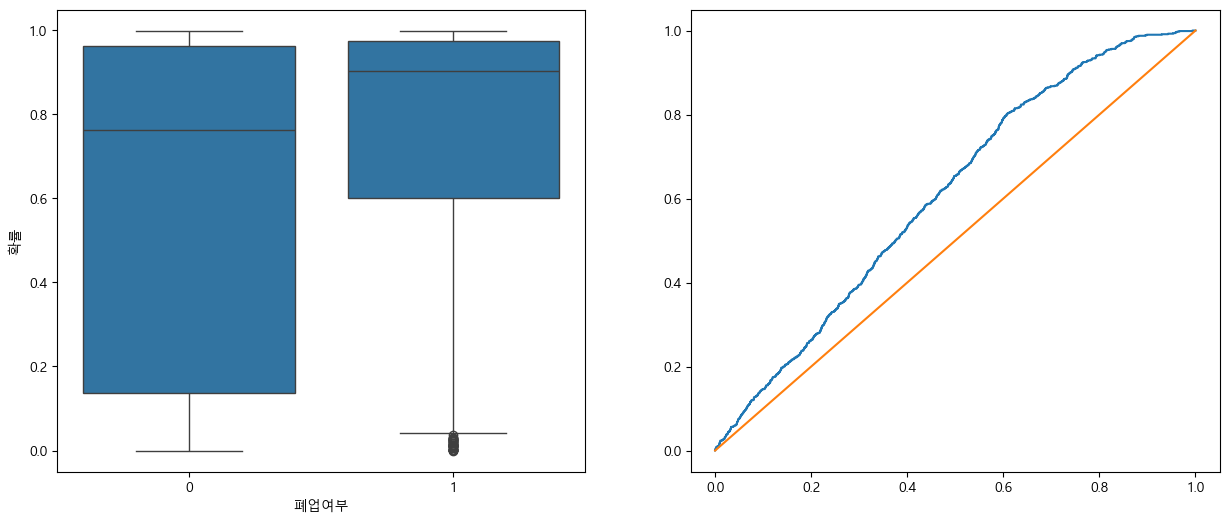

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plotting Probabilities
temp = pd.concat([pd.Series(y_test).rename('폐업여부'), pd.Series(y_pred_prob).rename('확률')], axis=1)
sns.boxplot(x='폐업여부', y='확률', data=temp, ax=ax[0])

# AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label='ROC'),
plt.plot([0, 1], [0, 1])

plt.show()

In [40]:
# Metrics
cm = confusion_matrix(y_test, y_pred)
print("0-1 proportion at test set :", y_test.value_counts().values)
print("accuracy score :", accuracy_score(y_test, y_pred))
# print("precision score :", precision_score(y_test, y_pred))
print("sensitivitiy :", cm[0][0]/(cm[0][0]+cm[0][1]))
print("recall score :", recall_score(y_test, y_pred))
print("average accuracy :", np.mean([cm[0][0]/(cm[0][0]+cm[0][1]), recall_score(y_test, y_pred)]))
# print("f1_score :", f1_score(y_test, y_pred))
print("AUC score :", roc_auc_score(y_test, y_pred))

0-1 proportion at test set : [53308   800]
accuracy score : 0.525523028018038
sensitivitiy : 0.5240676821490208
recall score : 0.6225
average accuracy : 0.5732838410745105
AUC score : 0.5732838410745105


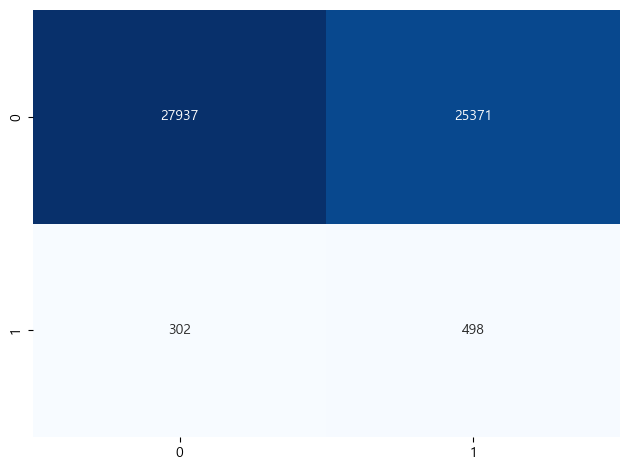

In [41]:
# Confusion Matrix
sns.heatmap(cm, cbar = False, annot=True, cmap = 'Blues', fmt='g')
plt.tight_layout()
plt.show()

In [37]:
y_pred = (y_pred_prob >= 0.8).astype(int)

In [ ]:
a_lst, r_lst, f1_lst, auc_lst = [], [], [], []
threshold_lst = np.arange(0, 1, 0.01)
for threshold in threshold_lst:
    y_pred_ts = (y_preb_prob >= threshold).astype(int)
    a_lst.append(accuracy_score(y_test, y_pred_ts))
    # precision_lst.append(precision_score(y_test, y_pred_ts))
    r_lst.append(recall_score(y_test, y_pred_ts))
    f1_lst.append(f1_score(y_test, y_pred_ts))
    auc_lst.append(roc_auc_score(y_test, y_pred_ts))

plt.plot(threshold_lst, a_lst, marker='o', markersize=0.1, label='accuracy')
# plt.plot(threshold_lst, precision_lst, marker='o', markersize=0.1, label='precision')
plt.plot(threshold_lst, r_lst, marker='o', markersize=0.1, label='recall')
plt.plot(threshold_lst, f1_lst, marker='o', markersize=0.1, label='f1_lst')
plt.plot(threshold_lst, auc_lst, marker='o', markersize=0.1, label='auc')
# plt.xlabel('threshold')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
## Feature Importance
ser = pd.Series(cat_model.feature_importances_, index=X_res2.columns)
ser = ser.sort_values(ascending=False)

plt.figure(figsize=(16, 10))
sns.barplot(x = ser, y=ser.index)
plt.show()